# Algorithmen aus dem Buch Kapitel 10 Data Mining

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sklearn.datasets
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns
import urllib
from pathlib import Path
import tarfile
import hashlib
import scipy
import sys
sys.version_info
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True  # Use per default a grid, i.e. plt.grid()
import itertools
from collections import namedtuple
from dataclasses import dataclass

## Klassifikation 

Bei dieser Art von Problemen geht es darum Daten möglichst gut zu klassifizieren.

Beispielsweise bei Früchten zu unterscheiden, ob diese eine Apfel oder eine Birne ist.

Nun wollen wir uns zunächst ein paar einfache Daten Mengen angucken und überlegen, ob wir bei diesen eine linearen Diskreminante finden.

### Generieren der Daten, die wir Klassifzieren wollen

In [2]:
@dataclass
class Dataset:
    name: str
    features: np.array 
    labels: np.array 

In [3]:
def generate_circles_dataset(number_of_samples=1000, random_state=np.random):
    labels = random_state.choice([0, 1], size=number_of_samples)
    features = random_state.normal(size=(number_of_samples, 2))
    features /= np.linalg.norm(features, axis=-1, keepdims=True)
    features *= labels[:, None] + 1 / 1.1 * random_state.uniform(size=number_of_samples)[:, None]
    return Dataset('circles', features, labels)

def generate_blobs_dataset(number_of_samples=1000, scale=1, random_state=np.random, name='blobs'):
    labels = random_state.choice([0, 1], size=number_of_samples)
    cluster_centers = random_state.normal(scale=scale, size=(2, 2))
    features = cluster_centers[labels, :] + random_state.normal(size=(number_of_samples, 2))
    return Dataset(name, features, labels)

In [4]:
blobs = generate_blobs_dataset(scale=2.2, random_state=np.random.RandomState(0), name='blobs')
circles = generate_circles_dataset(random_state=np.random.RandomState(0))
hard_blobs = generate_blobs_dataset(scale=1, random_state=np.random.RandomState(0), name='hard_blobs')

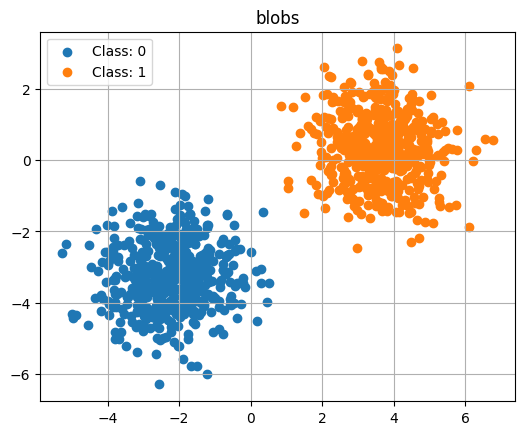

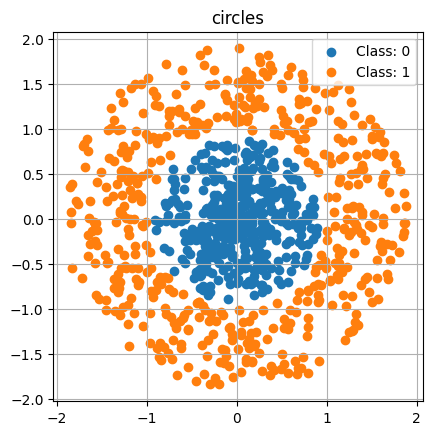

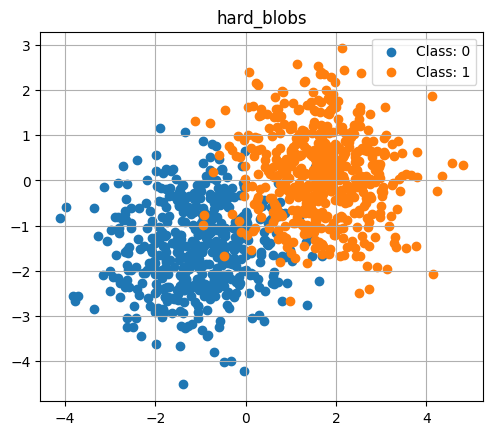

In [5]:
def plot_dataset(dataset, ax=None, title=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    classes = np.unique(dataset.labels)
    classes = np.sort(classes)
    for c in classes:
        ax.scatter(
            dataset.features[dataset.labels == c, 0],
            dataset.features[dataset.labels == c, 1],
            label=f'Class: {c}',
        )
    ax.set_aspect('equal')
    if title is None:
        title = dataset.name
    ax.set_title(title)
    ax.legend()


plot_dataset(blobs)
plot_dataset(circles)
plot_dataset(hard_blobs)


Nun müssen wir noch unsere beiden Datensets in Training und Test Sets aufteilen. Dies übernimmt der folgede Code:

In [6]:
def split_blobs(number_of_samples=200):
    return Dataset('train_blobs', blobs.features[0:number_of_samples], blobs.labels[0:number_of_samples]), Dataset('test_blobs', blobs.features[number_of_samples:], blobs.labels[number_of_samples:])

def split_circles(number_of_samples=200):
    return Dataset('train_circles', circles.features[0:number_of_samples], circles.labels[0:number_of_samples]), Dataset('test_circles', circles.features[number_of_samples:], circles.labels[number_of_samples:])

def split_hard_blobs(number_of_samples=200):
    return Dataset('train_hard_blobs', hard_blobs.features[0:number_of_samples], hard_blobs.labels[0:number_of_samples]), Dataset('test_hard_blobs', hard_blobs.features[number_of_samples:], hard_blobs.labels[number_of_samples:])

train_blobs, test_blobs = split_blobs()
train_circles, test_circles = split_circles()
train_hard_blobs, test_hard_blobs = split_hard_blobs()

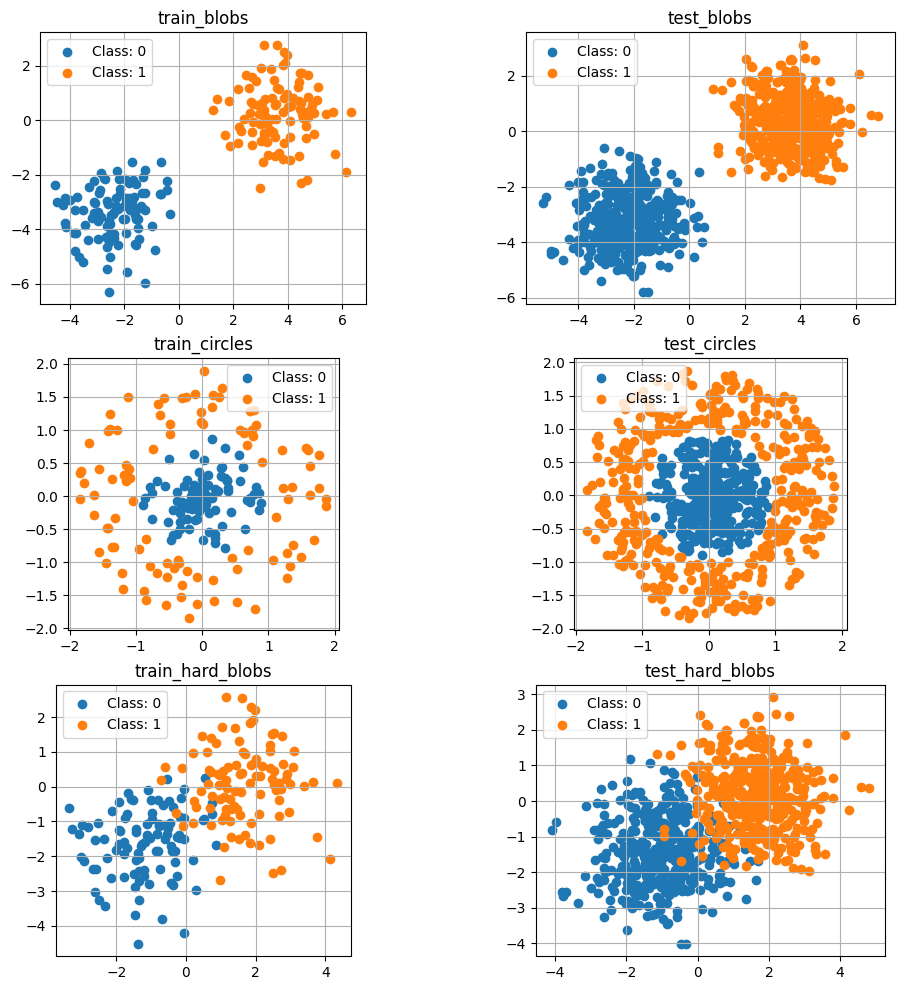

In [7]:
figure, axes = plt.subplots(3, 2, figsize=(12, 12))
plot_dataset(train_blobs, ax=axes[0, 0])
plot_dataset(test_blobs, ax=axes[0, 1])
plot_dataset(train_circles, ax=axes[1, 0])
plot_dataset(test_circles, ax=axes[1, 1])
plot_dataset(train_hard_blobs, ax=axes[2, 0])
plot_dataset(test_hard_blobs, ax=axes[2, 1])

### K-NN

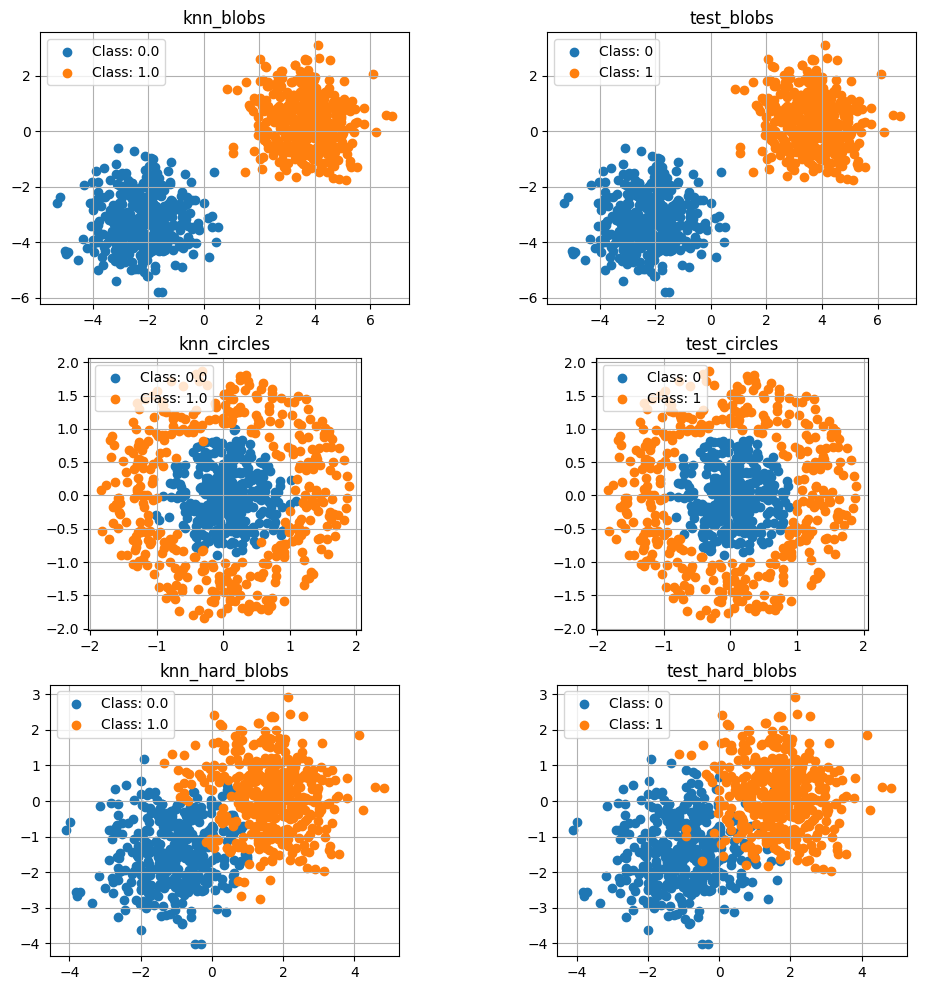

In [8]:
def knn(test : Dataset, valid : Dataset , k=1):
    distances = np.sum((test.features[:, None] - valid.features[None]) ** 2, axis=-1)
    nearest = np.argsort(distances, axis=-1)[:, :k]
    return np.mean(valid.labels[nearest], axis=-1)
def knn_decision_boundary(train : Dataset, test : Dataset, k=1):
    x_min, x_max = test.features[:, 0].min() - 1, test.features[:, 0].max() + 1
    y_min, y_max = test.features[:, 1].min() - 1, test.features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = knn(Dataset('decision_boundary', np.c_[xx.ravel(), yy.ravel()], np.zeros(xx.ravel().shape)), train, k=k)
    Z = Z.reshape(xx.shape)
    return xx, yy, Z
def plot_decision_boundary(decision_boundary, train_blobs, test_blobs):
    figure, axes = plt.subplots(1, 1, figsize=(6, 6))
    plot_dataset(train_blobs, ax=axes)
    plot_dataset(test_blobs, ax=axes)
    xx, yy, Z = knn_blobs_decision_boundary
    axes.contourf(xx, yy, Z, alpha=0.4)
    axes.set_xlim(xx.min(), xx.max())
    axes.set_ylim(yy.min(), yy.max())
    return figure, axes
knn_circles = Dataset('knn_circles', test_circles.features , knn(test_circles, train_circles, k=1))
knn_blobs = Dataset('knn_blobs',test_blobs.features , knn(test_blobs, train_blobs, k=1))
knn_hard_blobs = Dataset('knn_hard_blobs', test_hard_blobs.features , knn(test_hard_blobs, train_hard_blobs, k=1))
knn_circles_decision_boundary = knn_decision_boundary(train_circles, test_circles, k=1)
knn_blobs_decision_boundary = knn_decision_boundary(train_blobs, test_blobs, k=1)
knn_hard_blobs_decision_boundary = knn_decision_boundary(train_hard_blobs, test_hard_blobs, k=1)
figure, axes = plt.subplots(3, 2, figsize=(12, 12))
plot_dataset(knn_blobs, ax=axes[0, 0])
plot_dataset(test_blobs, ax=axes[0, 1])
plot_dataset(knn_circles, ax=axes[1, 0])
plot_dataset(test_circles, ax=axes[1, 1])
plot_dataset(knn_hard_blobs, ax=axes[2, 0])
plot_dataset(test_hard_blobs, ax=axes[2, 1])

### LDA

Wie bereits in meinem Vortrag erklärt, handelt es sich hierbei um einen Spezialfall: Wir nehmen an, dass die Diskreminante linear ist.

Welche unserer Sample Muster sind dann übehaupt noch sinnvoll?

Hier noch einmal die loglikelihood function, welche wir optimieren wollen:
\begin{align}
\ell( w_0, \mathbf w) &= \sum_{n=1}^N \bigg(
\tilde c_n \ln \, \sigma(\mathbf w^{\mathsf T}\mathbf x_n + w_0) + (1-\tilde c_n)\ln\,\big(1-\sigma(\mathbf w^{\mathsf T}\mathbf x_n + w_0)\big)
\bigg) \\
\tilde c_n &\in \{0, 1\}
\end{align}

Da wir diese loss function mit gradient Methoden optimieren wollen, müssen wir zu nächst die Ableitugen der einzelnen Bestandteile berechnen.
\begin{align}
\frac{\partial \sigma(x)}{\partial x}
&= -\frac{1}{(1+\mathrm e^{-x})^2} \cdot \mathrm e^{-x} \cdot (-1) \\  % REPLACE &= \color{red}{???}
&= \frac{\mathrm e^{-x}}{(1+\mathrm e^{-x})^2} \\  % REPLACE
&= \color{red}{\frac{1}{1+\mathrm e^{-x}}} \cdot \color{green}{\frac{\mathrm e^{-x}}{1+\mathrm e^{-x}}} \\  % REPLACE
&= \color{red}{\sigma(x)} \cdot \color{green}{(1-\sigma(x))}  % REPLACE
\end{align}

Folglich ist die Abeleitung der Kostenfunktion selber: 

\begin{align}
\frac{\partial\ell}{\partial w_0}
&= \sum_{n=1}^N \bigg(  % REPLACE &= \color{red}{???}
\tilde c_n \cdot \frac{1}{\sigma(\dots)} \cdot \sigma(\dots) \cdot \big(1-\sigma(\dots)\big)  % REPLACE
+ (1 - \tilde c_n) \cdot \frac{1}{1-\sigma(\dots)} \cdot (-1) \sigma(\dots) \cdot \big(1-\sigma(\dots)\big)  % REPLACE
\bigg) \\  % REPLACE
&= \sum_{n=1}^N \bigg(  % REPLACE
\tilde c_n \big(1-\sigma(\dots)\big)  % REPLACE
- (1 - \tilde c_n) \sigma(\dots)  % REPLACE
\bigg) \\  % REPLACE
&= \sum_{n=1}^N \bigg(  % REPLACE
\tilde c_n - \sigma(\mathbf w^{\mathsf T} \mathbf x_n + w_0)  % REPLACE
\bigg)  % REPLACE
\end{align}

\begin{align}
\frac{\partial\ell}{\partial w_d}
&= \sum_{n=1}^N \bigg(  % REPLACE &= \color{red}{???}
\tilde c_n \cdot \frac{1}{\sigma(\dots)} \cdot \sigma(\dots) \cdot \big(1-\sigma(\dots)\big) x_{d,n}  % REPLACE
+ (1 - \tilde c_n) \cdot \frac{1}{1-\sigma(\dots)} \cdot (-1) \sigma(\dots) \cdot \big(1-\sigma(\dots)\big) x_{d,n}  % REPLACE
\bigg) \\  % REPLACE
&= \sum_{n=1}^N x_{d,n} \bigg(  % REPLACE
\tilde c_n \big(1-\sigma(\dots)\big)  % REPLACE
- (1 - \tilde c_n) \sigma(\dots)  % REPLACE
\bigg) \\  % REPLACE
&= \sum_{n=1}^N x_{d,n} \bigg(  % REPLACE
\tilde c_n - \sigma(\mathbf w^{\mathsf T} \mathbf x_n + w_0)  % REPLACE
\bigg)  % REPLACE
\end{align}


\begin{align}
\mathbf w^{(\kappa + 1)}
&= \mathbf w^{(\kappa)} + \mu \left.\frac{\partial\ell}{\partial \mathbf w}\right|_{w_0^{(\kappa)}, \mathbf w^{(\kappa)}} &  % REPLACE &= \color{red}{???} &
w_0^{(\kappa + 1)}
&= w_0^{(\kappa)} + \mu \left.\frac{\partial\ell}{\partial \mathbf w}\right|_{w_0^{(\kappa)}, \mathbf w^{(\kappa)}}  % REPLACE &= \color{red}{???}
\end{align}

## Gradient Decent

Im folgenden sind 3 Gradient Decent verfahren implimentiert.

### Classic Gradient Decent

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def gradient_decent(w, w0, test: Dataset, learning_rate=0.1, epochs=1000):
    for _ in range(epochs):
        grad_w0 = np.sum(test.labels - sigmoid( np.dot(w,test.features) + w0), axis=0)  
        grad_w = np.sum(((test.labels - sigmoid(np.dot(w) + w0)))[:, None] * test.features, axis=0)
        w0 += learning_rate * grad_w0
        w += learning_rate * grad_w
    return w, w0

Die hierdurch erreichte Entscheidungsregel: 

In [10]:
def compute_complete_grid(xlim, ylim, steps):
    x, y = np.meshgrid(
        np.linspace(*xlim, steps),
        np.linspace(*ylim, steps)
    )
    features_grid = np.moveaxis(np.array([x, y]), source=0, destination=-1)
    assert features_grid.shape == (steps, steps, 2), features_grid.shape
    return x, y, features_grid

steps = 100
x, y, features_grid = compute_complete_grid((0, 7), (0, 3), steps=steps)

z = sigmoid(features_grid @ w + w0)

plt.contourf(x, y, z)
plt.clim(0, 1)
plt.colorbar(label='Estimated class probability')

add_scatter_to_plot(train_blobs, test_blobs)
plt.show()

NameError: name 'w' is not defined

### Stochastic Gradient Decent

### Mini Batch Stochastic Gradient Decent 

## K - Means Clustering 

Ein Algo. der im Kontext von unsupervised learning verwendet wird

In [ ]:
def cluster_samples(N = 1500, p = np.array([0.3, 0.6, 0.4]), K = p.shape[0], D = 2):
    means = np.array([[-1, -1], [1, 1], [-2, 2]])
    x = np.sqrt(1 / 4) * np.random.normal(size=(N, D))
    for k in range(K):
        x[labels == k, :] += means[k, :]
    return Dataset('cluster_samples', x, N*[0])

test_cluster_samples = cluster_samples()
plot_dataset(test_cluster_samples)

NameError: name 'p' is not defined

Implementation des K-Means Clustering

In [ ]:
def k_means_clustering(test : Dataset, K = 3, max_iter = 100):
    N, D = test.features.shape
    means = test.features[np.random.choice(N, K, replace=False)]
    for _ in range(max_iter):
        distances = np.sum((test.features[:, None] - means[None]) ** 2, axis=-1)
        labels = np.argmin(distances, axis=-1)
        for k in range(K):
            means[k] = np.mean(test.features[labels == k], axis=0)
    return Dataset('k_means_clustering', test.features, labels)
plot_dataset(k_means_clustering(test_cluster_samples))

NameError: name 'test_cluster_samples' is not defined